In [1]:
# training_general_tensor-with_augment_layer
# pip install opencv-python

In [2]:
import matplotlib
import sklearn
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import pathlib
import os
import cv2
import datetime

from os import listdir
from os.path import isfile, isdir, join
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("numpy:      ", np.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn:    ", sklearn.__version__)
print(tf.config.list_physical_devices())

Versions of key libraries
---
tensorflow:  2.9.0
numpy:       1.22.3
matplotlib:  3.5.2
sklearn:     1.1.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
modelname   = 'general-simple'

IMG_SIZE = 128 #224 # Specify height and width of image to match the input format of the model
IMG_WIDTH = 128 #224  #IMG_SIZE
IMG_HEIGHT = 128  #160  #IMG_SIZE
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 32 # Big enough to measure an F1-score
AUTOTUNE = tf.data.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 1024 # Shuffle the training data by a chunck of 1024 observations
SEED = 7
N_LABELS = 0
EPOCHS = 80
OPT_IDX = 2
ACTIVATION = 'softmax'

class_names = []
modelname = modelname+"_"+ACTIVATION+"_"+str(IMG_SIZE)+"_"+str(EPOCHS)+"_"+str(BATCH_SIZE)+"_"+str(OPT_IDX)
optmzs = ['adam', optimizers.RMSprop(learning_rate=0.0001), optimizers.Adam(learning_rate=0.001)]
optmz = optmzs[OPT_IDX]

In [4]:
def readImagesFromDir(base_img_path='dataset/'):
    dirs = [d for d in listdir(base_img_path) if isdir(join(base_img_path, d)) and not d.startswith('.') and not d in ['oranda', 'common_goldfish']]

    print(dirs)

    X, y = [], []

    for d in dirs:
        img_path = base_img_path + d + "/"
        files = [f for f in listdir(img_path) if isfile(join(img_path, f))]
        X = X + [os.path.join(img_path, f) for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        y = y + [d for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        #print(d)

    data_dir = Path(base_img_path)
    image_count = len(list(data_dir.glob('*/*.*')))
    
    return X, y


def preprocess_image(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    #image_resized = tf.image.resize(image_decoded, [IMG_HEIGHT, IMG_WIDTH], preserve_aspect_ratio=True)
    image_resized = tf.image.resize_with_pad(image_decoded, IMG_HEIGHT, IMG_WIDTH, antialias=False)
    #image_cropped = tf.image.random_crop(image_resized, [IMG_HEIGHT, IMG_WIDTH, CHANNELS])
    #image_rotated = tf.image.rot90(image_resized, k=0)
    #image_flip = tf.image.flip_left_right(image_rotated)
    # Normalise the image
    #visualize_image(image_cropped, image_rotated)
    image_normalized = image_resized / 255.0
    
    return image_normalized, label


def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """
    
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        #dataset = dataset.take(BATCH_SIZE)
        # This is a small dataset, only load it once, and keep it in memory.
        #dataset = dataset.cache()
        #dataset = dataset.repeat()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        #dataset = dataset.repeat()
        
    # Batch the data for multiple steps    
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset
    
def visualize_image(original, augmented):
    org_img = tf.keras.utils.array_to_img(original)
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(org_img)

    aug_img = tf.keras.utils.array_to_img(augmented)
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(aug_img)


def predict_new_image(img_file):    
    #img = tf.keras.utils.load_img(
    #    img_file, target_size=(IMG_HEIGHT, IMG_WIDTH), keep_aspect_ratio=True
    #)
    img = tf.keras.utils.load_img(
        img_file, target_size=None, keep_aspect_ratio=True
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.keras.preprocessing.image.smart_resize(img_array, size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    image_normalized = img_array / 255.0  # tf.image.per_image_standardization(img_array)

    saved_model = load_model(model_file)

    predictions = saved_model.predict(image_normalized)
    score = tf.nn.softmax(predictions[0])
    #score = tf.sigmoid(predictions[0])
    #score = tf.nn.sigmoid_cross_entropy_with_logits(labels=class_names, logits=predictions[0])
    #score = tf.math.sigmoid(predictions[0])
    #score = tf.tanh(predictions[0])

    #model.evaluate(img_array)
    plt.imshow(img)
    plt.show()

    #print(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print()

In [5]:
X, Y = readImagesFromDir()

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)

lb = LabelBinarizer()
lb.fit(y_train)
class_names = lb.classes_
# Loop over all labels and show them    
N_LABELS = len(class_names)
for (i, label) in enumerate(class_names):
    print("{}. {}".format(i, label))

# transform the targets of the training and test sets
y_train_bin = lb.transform(y_train)
y_val_bin = lb.transform(y_val)

print(y_train_bin.shape)
print(y_val_bin.shape)

['arowana', 'betta', 'goldfish', 'luohan']
0. arowana
1. betta
2. goldfish
3. luohan
(9164, 4)
(2291, 4)


In [6]:
# Print examples of fish and their binary targets
for i in range(10):
    print(X_train[len(X_train)-1 - i], y_train_bin[len(y_train_bin)-1 - i])

dataset/luohan/Flowerhorn10383.jpg [0 0 0 1]
dataset/arowana/240_F_73601716_vduxsAMnoi1s681yzgQQa7WmvEUNeFuQ.jpg [1 0 0 0]
dataset/luohan/Flowerhorn11713.jpg [0 0 0 1]
dataset/betta/BettaFish11694.jpg [0 1 0 0]
dataset/betta/BettaFish10302.jpg [0 1 0 0]
dataset/arowana/Arowana_100303.jpg [1 0 0 0]
dataset/arowana/Arowana_100756.jpg [1 0 0 0]
dataset/goldfish/Goldfish2519.jpg [0 0 1 0]
dataset/arowana/Arowana_101967.jpg [1 0 0 0]
dataset/betta/BettaFish10436.jpg [0 1 0 0]


Shape of features array: (32, 128, 128, 3)
Shape of labels array: (32, 4)


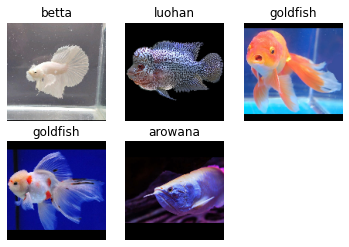

In [7]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin, is_training=False)


for images, labels in train_ds.take(1):
    print("Shape of features array:", images.numpy().shape)
    print("Shape of labels array:", labels.numpy().shape)
    #plt.imshow(f.numpy().astype("uint8"))
    for i in range(5):
        ax = plt.subplot(2, 3, i + 1)
        img = tf.keras.utils.array_to_img(images[i])
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    

In [8]:
image_augmentation = keras.Sequential(
  [
    layers.RandomFlip(mode="horizontal_and_vertical",
                      input_shape=(IMG_HEIGHT,
                                   IMG_WIDTH,
                                   CHANNELS), seed=SEED),
    layers.RandomRotation(0.2, seed=SEED)
    #layers.RandomZoom(0.2, (0.2, 0.3)),
  ]
)

In [9]:
def createModel():
    model = Sequential()
    model.add(image_augmentation)
    model.add(Conv2D(32, (5,5), padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH,CHANNELS), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (4,4), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Conv2D(32, (5,5), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Conv2D(64, (4,4), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(64, (4,4), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(64, (4,4), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.0001), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Conv2D(1024, (2,2), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2,2)))
    #model.add(Dropout(0.2))
    model.add(Flatten())
    #model.add(Dense(768, activation='relu'))
    #model.add(Dense(512, activation='relu'))
    #model.add(Dense(256, activation='relu'))
    #model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(N_LABELS, activation=ACTIVATION))
    model.compile(loss='categorical_crossentropy', optimizer=optmz, metrics=['accuracy'])
    return model

model       = createModel() # This is meant for training

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)       

In [10]:
                                                                                # Step 1
modelname       = modelname+"_"+str(datetime.datetime.now())[:-7].replace(' ','_').replace(":",'-')
folderpath      = 'models/'
model_file      = folderpath + modelname + ".hdf5"
checkpoint      = ModelCheckpoint(model_file, 
                                  monitor='val_accuracy', 
                                  verbose=0, 
                                  save_best_only=True, 
                                  mode='max')

csv_logger      = CSVLogger(folderpath+modelname +'.csv')                       # Step 2
callbacks_list  = [checkpoint,csv_logger]                                       # Step 3

print("Path to model:", model_file)
print("Path to log:  ", folderpath+modelname+'.csv')

Path to model: models/general-simple_softmax_128_80_32_2_2022-10-24_22-19-42.hdf5
Path to log:   models/general-simple_softmax_128_80_32_2_2022-10-24_22-19-42.csv


In [11]:
plotpath  = folderpath+modelname+'_plot.png'
plot_model(model, 
           to_file=plotpath, 
           show_shapes=True, 
           show_layer_names=False,
           rankdir='TB')
print("Path to plot:", plotpath)

Path to plot: models/general-simple_softmax_128_80_32_2_2022-10-24_22-19-42_plot.png


In [12]:
import time as time

start = time.time()
history = model.fit(train_ds,                            # Training data and label
          validation_data=val_ds,   # Validation data and label
          epochs=EPOCHS,                       # The amount of epochs to be trained
          batch_size=BATCH_SIZE,                   
          shuffle=True,                     # To shuffle the training data
          callbacks=callbacks_list)         # Callbacks to execute the checkpoints

end = time.time()
duration = round(((end - start)/60), 2)
print("duration = ", duration, " minutes")

Epoch 1/80
287/287 [==============================] - 18s 47ms/step - loss: 1.0945 - accuracy: 0.5347 - val_loss: 0.8759 - val_accuracy: 0.6591
Epoch 2/80
287/287 [==============================] - 14s 45ms/step - loss: 0.8396 - accuracy: 0.6733 - val_loss: 0.7956 - val_accuracy: 0.6901
Epoch 3/80
287/287 [==============================] - 14s 46ms/step - loss: 0.7332 - accuracy: 0.7250 - val_loss: 0.6718 - val_accuracy: 0.7573
Epoch 4/80
287/287 [==============================] - 14s 46ms/step - loss: 0.6696 - accuracy: 0.7461 - val_loss: 0.6163 - val_accuracy: 0.7665
Epoch 5/80
287/287 [==============================] - 14s 46ms/step - loss: 0.6138 - accuracy: 0.7705 - val_loss: 0.7280 - val_accuracy: 0.7429
Epoch 6/80
287/287 [==============================] - 14s 46ms/step - loss: 0.5789 - accuracy: 0.7844 - val_loss: 0.5041 - val_accuracy: 0.8097
Epoch 7/80
287/287 [==============================] - 14s 48ms/step - loss: 0.5331 - accuracy: 0.8043 - val_loss: 0.5079 - val_accuracy:

287/287 [==============================] - 14s 47ms/step - loss: 0.2081 - accuracy: 0.9334 - val_loss: 0.2981 - val_accuracy: 0.9092
Epoch 58/80
287/287 [==============================] - 14s 48ms/step - loss: 0.2140 - accuracy: 0.9318 - val_loss: 0.3236 - val_accuracy: 0.9027
Epoch 59/80
287/287 [==============================] - 14s 48ms/step - loss: 0.2087 - accuracy: 0.9322 - val_loss: 0.2707 - val_accuracy: 0.9245
Epoch 60/80
287/287 [==============================] - 14s 48ms/step - loss: 0.1942 - accuracy: 0.9423 - val_loss: 0.2498 - val_accuracy: 0.9249
Epoch 61/80
287/287 [==============================] - 14s 48ms/step - loss: 0.1936 - accuracy: 0.9394 - val_loss: 0.2488 - val_accuracy: 0.9267
Epoch 62/80
287/287 [==============================] - 15s 49ms/step - loss: 0.1976 - accuracy: 0.9385 - val_loss: 0.3183 - val_accuracy: 0.9070
Epoch 63/80
287/287 [==============================] - 14s 46ms/step - loss: 0.1990 - accuracy: 0.9371 - val_loss: 0.3739 - val_accuracy: 0.89

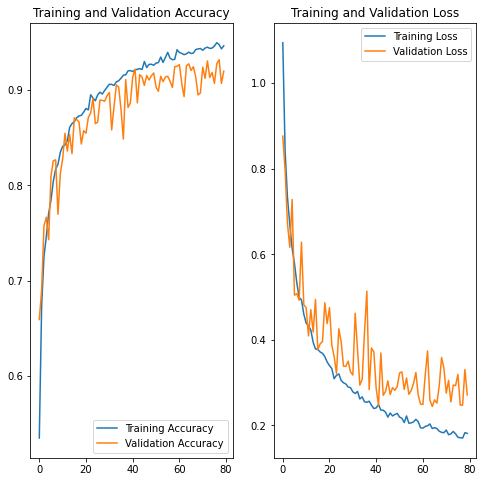

In [13]:
# Plot the accuracy and error on training and test sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig(folderpath+modelname+'_accuracy_plot.png')
plt.show()

In [14]:
                                                                                # Step 1
modelGo = load_model(model_file)

predicts    = modelGo.predict(val_ds)                                            # Step 2
print("Prediction completes.")

72/72 [==============================] - 1s 15ms/step
Prediction completes.


In [15]:
                                                                                # Step 1
                                                                                # Step 2
predout     = np.argmax(predicts,axis=1)
testout     = np.argmax(y_val_bin,axis=1)

testScores  = metrics.accuracy_score(testout,predout)                           # Step 3

                                                                                # Step 4
print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4))

report = metrics.classification_report(testout,
                                    predout,
                                    target_names=class_names,
                                    digits=4,
                                      output_dict=True)

df = pd.DataFrame(report).transpose()
df.to_csv(folderpath+modelname+'_report.csv')

Best accuracy (on testing dataset): 93.19%
              precision    recall  f1-score   support

     arowana     0.9300    0.9559    0.9428       612
       betta     0.9070    0.9590    0.9323       610
    goldfish     0.9511    0.8761    0.9121       444
      luohan     0.9474    0.9216    0.9343       625

    accuracy                         0.9319      2291
   macro avg     0.9339    0.9282    0.9304      2291
weighted avg     0.9327    0.9319    0.9317      2291



In [16]:
resdf = pd.DataFrame()
resdf["file"] = X_val
resdf["fish"] = y_val
resdf["testout"] = testout
resdf["predout"] = predout
wrong_pred = resdf[resdf.testout !=resdf.predout]
wrong_pred

,file,fish,testout,predout
0,dataset/goldfish/Goldfish1555.jpg,goldfish,2,1
13,dataset/luohan/Flowerhorn10798.jpg,luohan,3,0
14,dataset/luohan/depositphotos_134954534-stock-p...,luohan,3,0
19,dataset/goldfish/Goldfish3021.jpg,goldfish,2,1
34,dataset/arowana/Arowana_101879.jpg,arowana,0,2
...,...,...,...,...
2264,dataset/goldfish/Goldfish1080.jpg,goldfish,2,1
2266,dataset/arowana/Arowana_101850.jpg,arowana,0,1
2272,dataset/goldfish/Goldfish2459.jpg,goldfish,2,3
2283,dataset/goldfish/Goldfish2542.jpg,goldfish,2,1


1/1 [==============================] - 0s 118ms/step


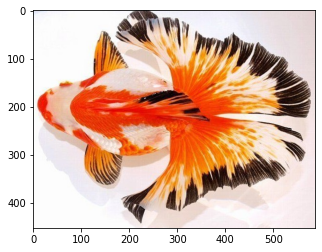

This image most likely belongs to betta with a 47.54 percent confidence.

File: dataset/goldfish/Goldfish1555.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta
1/1 [==============================] - 0s 60ms/step


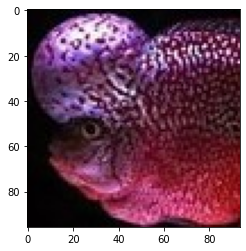

This image most likely belongs to arowana with a 46.67 percent confidence.

File: dataset/luohan/Flowerhorn10798.jpg with type luohan 
expected out 	luohan 
predicted out 	arowana
1/1 [==============================] - 0s 63ms/step


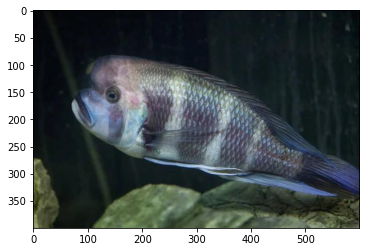

This image most likely belongs to arowana with a 39.83 percent confidence.

File: dataset/luohan/depositphotos_134954534-stock-photo-frontosa-cyphotilapia-frontosa.jpg with type luohan 
expected out 	luohan 
predicted out 	arowana
1/1 [==============================] - 0s 71ms/step


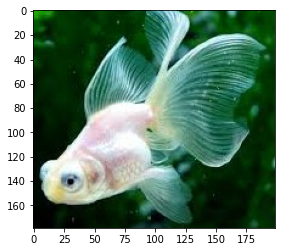

This image most likely belongs to betta with a 38.59 percent confidence.

File: dataset/goldfish/Goldfish3021.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta
1/1 [==============================] - 0s 72ms/step


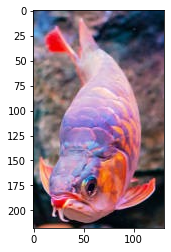

This image most likely belongs to arowana with a 35.49 percent confidence.

File: dataset/arowana/Arowana_101879.jpg with type arowana 
expected out 	arowana 
predicted out 	goldfish
1/1 [==============================] - 0s 66ms/step


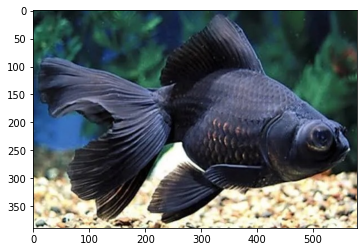

This image most likely belongs to arowana with a 37.28 percent confidence.

File: dataset/goldfish/Goldfish1467.jpg with type goldfish 
expected out 	goldfish 
predicted out 	arowana
1/1 [==============================] - 0s 63ms/step


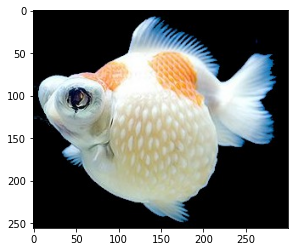

This image most likely belongs to betta with a 47.53 percent confidence.

File: dataset/goldfish/Goldfish1830.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta
1/1 [==============================] - 0s 66ms/step


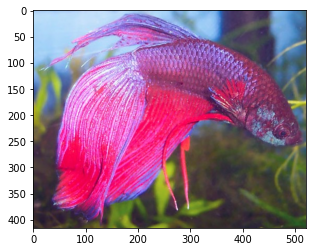

This image most likely belongs to betta with a 35.64 percent confidence.

File: dataset/betta/BettaFish10545.jpg with type betta 
expected out 	betta 
predicted out 	luohan
1/1 [==============================] - 0s 71ms/step


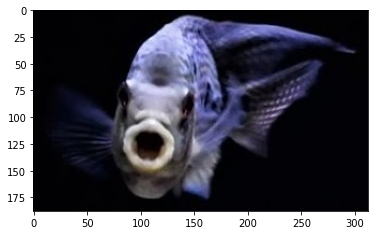

This image most likely belongs to arowana with a 43.34 percent confidence.

File: dataset/luohan/Flowerhorn12109.jpg with type luohan 
expected out 	luohan 
predicted out 	betta
1/1 [==============================] - 0s 63ms/step


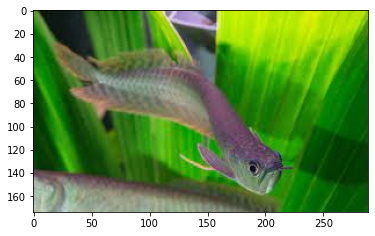

This image most likely belongs to betta with a 44.16 percent confidence.

File: dataset/arowana/download.jpg with type arowana 
expected out 	arowana 
predicted out 	luohan
1/1 [==============================] - 0s 62ms/step


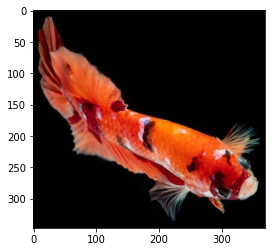

This image most likely belongs to goldfish with a 31.77 percent confidence.

File: dataset/betta/BettaFish11250.jpg with type betta 
expected out 	betta 
predicted out 	goldfish
1/1 [==============================] - 0s 62ms/step


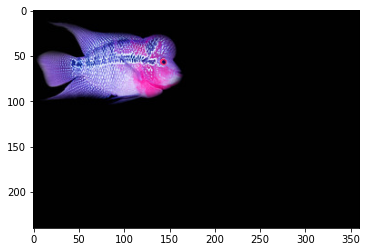

This image most likely belongs to luohan with a 31.35 percent confidence.

File: dataset/luohan/240_F_135889069_D2XqxGXkMUghWGdE4fYd1EO7ZB5n2Vi6.jpg with type luohan 
expected out 	luohan 
predicted out 	arowana
1/1 [==============================] - 0s 74ms/step


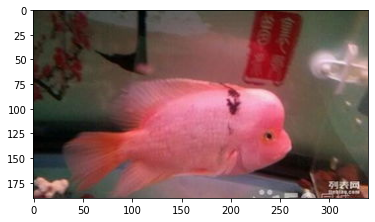

This image most likely belongs to goldfish with a 30.35 percent confidence.

File: dataset/luohan/8c6f773f513d46c9.jpg with type luohan 
expected out 	luohan 
predicted out 	arowana
1/1 [==============================] - 0s 85ms/step


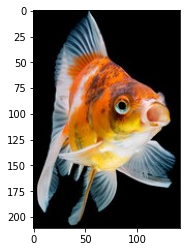

This image most likely belongs to goldfish with a 47.53 percent confidence.

File: dataset/goldfish/Goldfish1326.jpg with type goldfish 
expected out 	goldfish 
predicted out 	betta
1/1 [==============================] - 0s 62ms/step


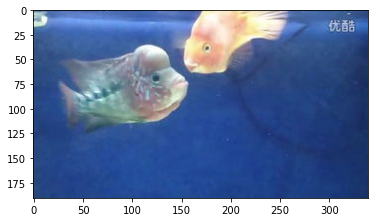

This image most likely belongs to luohan with a 36.57 percent confidence.

File: dataset/luohan/c8828c3d6ceba62b.jpg with type luohan 
expected out 	luohan 
predicted out 	arowana


In [17]:
# make predictions

for i in range(15):
    row = wrong_pred.iloc[i]
    predict_new_image(row.file)
    print("File: {} with type {} \nexpected out \t{} \npredicted out \t{}".format(row.file, row.fish, class_names[row.testout], class_names[row.predout]))
